In [21]:
# Importing packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
from camera_calib import camera_calibrate
from undistort import undist_image, imread_undist, plot_raw_undist
from binary import gen_mask
from warper import warper, plot_orig_warp
from fit_poly import find_lane_pixels

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
## Global Var Class ##
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([False])  
        #radius of curvature of the line in some units
        self.radius_pix = None 
        self.radius_m = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Linespace y values
        self.ploty = None
        #number of iterations to be stored
        self.n = 1
        
    def add_item(self, var, item):
        var.append(item)
        if len(var) > self.n:
            var.pop(0)
        return
        
    def compute_radius(self, mx, my):
        y_eval = self.ploty[-1]
        self.radius_pix = ((1 + (2 * self.current_fit[0] * y_eval + self.current_fit[1])**2)**1.5)/(2 * np.abs(self.current_fit[0]))
        
        # Polynomial equation in meters
        y_eval = y_eval * my
        fit_m =  [(mx / (my ** 2)) * self.current_fit[0], (mx/my) * self.current_fit[1], self.current_fit[2]]
        self.radius_m = ((1 + (2 * fit_m[0] * y_eval + fit_m[1])**2)**1.5)/(2 * np.abs(fit_m[0]))
        return self.radius_m
    
    def compute_base_pos(self, Minv, w, mx):
        self.line_base_pos = cv2.perspectiveTransform(np.float32([[[self.recent_xfitted[-1][-1], self.ploty[-1]]]]), Minv)[0][0][0] - (w / 2)
        self.line_base_pos = self.line_base_pos * mx
        return self.line_base_pos
        
        
        
class System():
    def __init__(self):
        ## Line variables
        self.left = Line()
        self.right = Line()
        
        ## Camera calibration
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        
        ## Perspective Projection (src, dst values are related to corresponding image)
        self.perspective_image = '../test_images/straight_lines1.jpg'
        self.src = np.float32([[206, 719], [1100, 719], [704, 462], [578, 462]])
        self.dst = np.float32([[280, 719], [1000, 719], [1000, 0], [280, 0]])
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        
        ## Pixel to real world conversion
        self.mx = 3.7/700
        self.my = 30/720
        
        ## Binary threshold params
        self.s_min = 150  # S channel min
        self.s_max = 250  # S channel min
        self.mag_min = 50   # grad magnitude min
        self.mag_max = 255  # grad magnitude max
        self.mag_kernel = 9 # grad magnitude kernel
        self.dir_min = 0.7  # grad direction min
        self.dir_max = 1.3  # grad direction max
        self.dir_kernel = 9 # grad direction kernel
        
        ## Parameters to choose pixels for lane detection
        self.nwindows = 9
        self.margin = 60
        self.minpix = 50
        
        ## Road param
        self.curvature = None
        self.offset = None
        
    def set_camera_calib(self, mtx, dist, rvecs, tvecs):
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs
        
    def compute_car_offset(self, w):
        left_dist = self.left.compute_base_pos(self.Minv, w, self.mx)
        right_dist = self.right.compute_base_pos(self.Minv, w, self.mx)
        self.offset = (left_dist + right_dist) / 2
        return self.offset
        
    def compute_radius(self):
        left_radius = self.left.compute_radius(self.mx, self.my)
        right_radius = self.right.compute_radius(self.mx, self.my)
        self.curvature = (left_radius + right_radius) / 2
        return self.curvature
    
    def debug(self):
#         print("Debug 1 : ", self.left.recent_xfitted[-1][-1], self.right.recent_xfitted[-1][-1])
        print("Debug 1 : ", self.left.current_fit, self.right.current_fit)
        pass
    
system = System()

## 1. Camera Calibration

In [47]:
# Get Camera Calibaration parameters using images from the path specified
_, mtx, dist, rvecs, tvecs = camera_calibrate('../camera_cal/calibration*.jpg', show_corners=0)

# Store these params into system
system.set_camera_calib(mtx, dist, rvecs, tvecs)

## 2. Undisorting sample raw image

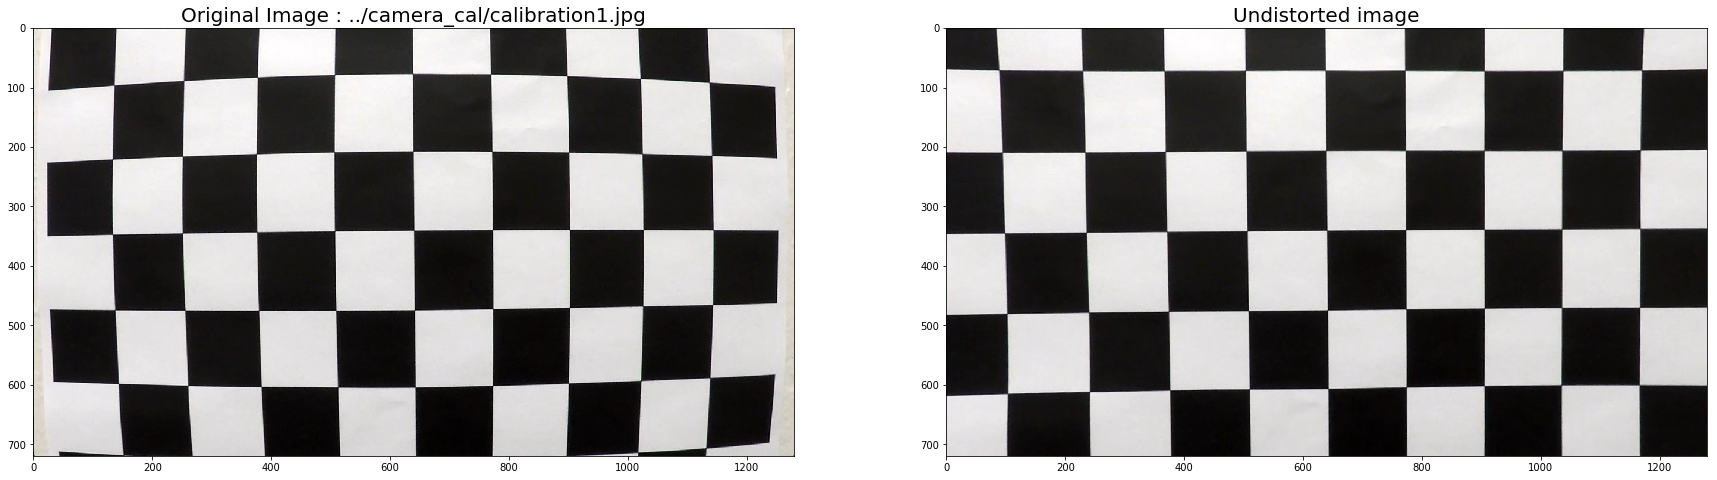

In [4]:
# Reading sample image for demonstrating undistortion
img_name = "../camera_cal/calibration1.jpg"
undist, raw = imread_undist(img_name, system)

# Show the raw and undistorted images
plot_raw_undist(raw, undist, img_name)

## 3. Thresholded binary image

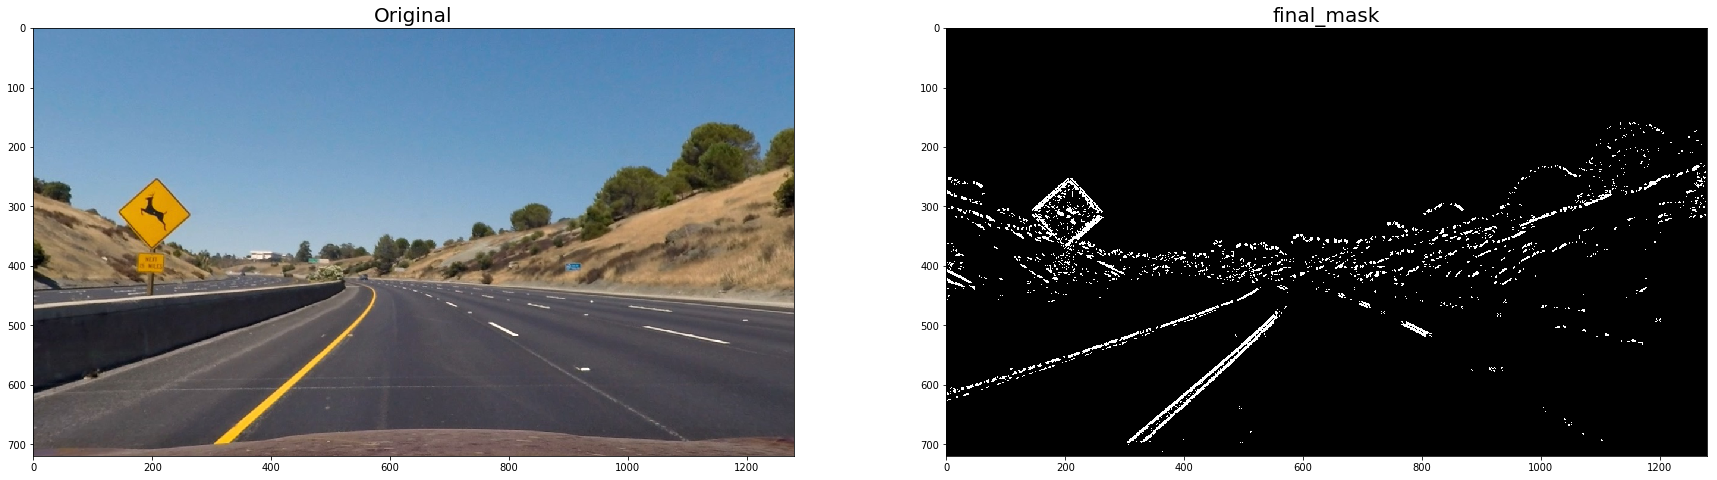

In [5]:
# Reading sample image for demonstrating binary thresholding
img_name = "../test_images/test2.jpg"
undist, _ = imread_undist(img_name, system)

# Generate the binary mask
binary = gen_mask(undist, system)

## 4. Birds-eye view of lanes

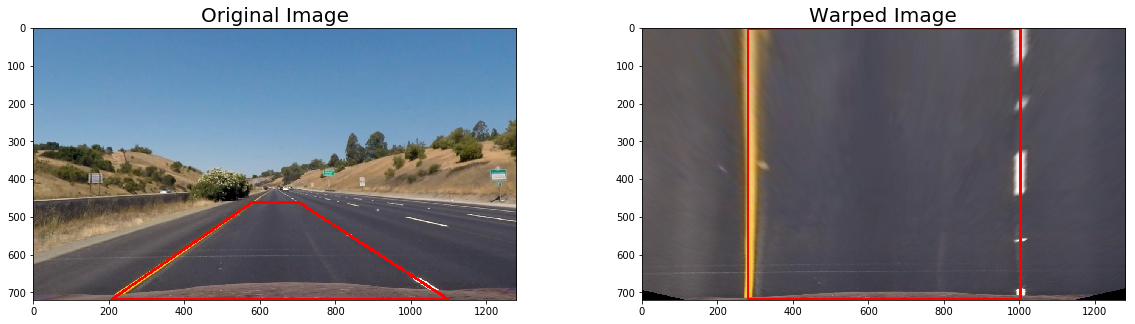

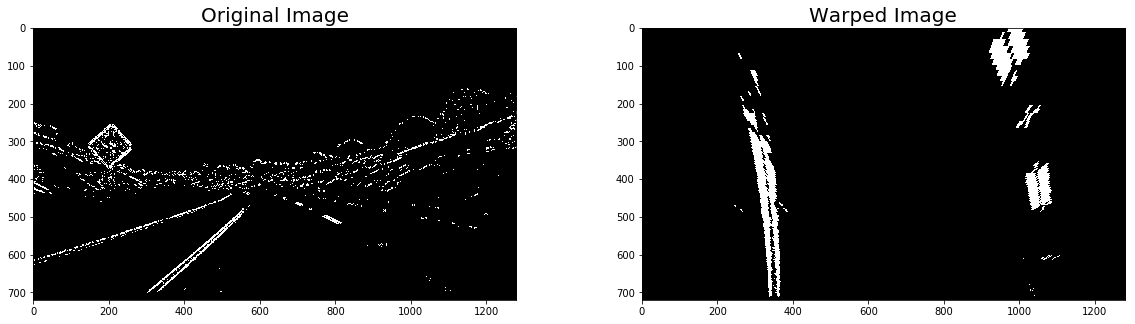

In [6]:
# Annotate the co-ordinates chosen for computing perspective projection matrix
undist, _ = imread_undist(system.perspective_image, system)
warped = warper(undist, system, resize = cv2.INTER_LINEAR)
annotate_src = cv2.polylines(np.copy(undist), [np.int32(system.src)], True, (255, 0, 0), 5)
annotate_dst = cv2.polylines(np.copy(warped), [np.int32(system.dst)], True, (255, 0, 0), 5)
plot_orig_warp(annotate_src, annotate_dst)
plt.savefig("../output_images/warped_straing_lines.jpg")

# Apply perspective projection on sample binary image
img_name = "../test_images/test2.jpg"
undist, _ = imread_undist(img_name, system)
binary = gen_mask(undist, system, show = 0)
warped = warper(binary, system)
plot_orig_warp(binary, warped, cmap="gray")

## 5. Computing Lane bounday

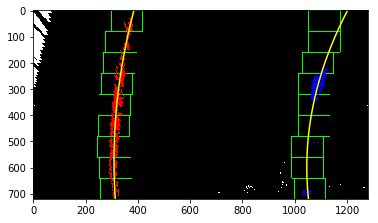

In [61]:
def save_line_vars(line, x, y, fit, fitx, ploty, Minv, w):
    line.allx = x
    line.ally = y
    line.current_fit = fit
    line.add_item(line.recent_xfitted, fitx)
    line.bestx = np.mean(np.array(line.recent_xfitted))
    line.ploty = ploty
    return
    
def fit_polynomial(binary_warped, system, show=1):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, system, show)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Dims of image
    h, w = binary_warped.shape[:2]
    
    # Save variables into system
    save_line_vars(system.left, leftx, lefty, left_fit, left_fitx, ploty, system.Minv, w)
    save_line_vars(system.right, rightx, righty, right_fit, right_fitx, ploty, system.Minv, w)
    
    ## Visualization ##
    # Plots the left and right polynomials on the lane lines
    if show:
        out_img[out_img[:,:,0] > 0] = [255, 255, 255]
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
    return left_fit, right_fit, ploty


sample_img = '../test_images/test1.jpg'
img, _ = imread_undist(sample_img, system)
bin_mask = gen_mask(img, system, show=0)
warp_img = warper(bin_mask, system)
_ = fit_polynomial(warp_img, system)


## 5. Measrue Curvature and car offset w.r.t center of lanes

In [62]:
car_offset = system.compute_car_offset(warp_img.shape[1])
curvature = system.compute_radius()

print("car offset : {}".format(car_offset))
print("curvature : {}".format(curvature))

car offset : 0.34999443926130036
curvature : 547.4623684849412


## 6. Lane bounday on image

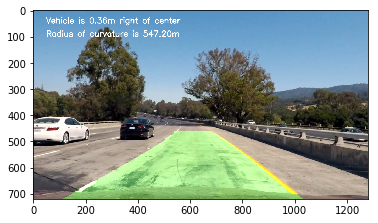

In [60]:
def color_lane(image, warped, system, show=0):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([system.left.recent_xfitted[-1], system.left.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([system.right.recent_xfitted[-1], system.right.ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    if show:
        plt.figure()
        plt.imshow(color_warp)
        
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, system.Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Car offset
    offset_real = system.offset
    offset_text = "Vehicle is {:.2f}m {} of center".format(abs(offset_real), "left" if offset_real > 0 else "right")
    
    # Curvature
    radius = system.curvature
    radius_text = "Radius of curvature is {:.2f}m".format(radius)
    
    # Add text to the image
    result = cv2.putText(result, offset_text, (50, 50) , cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255) , 2, cv2.LINE_AA) 
    result = cv2.putText(result, radius_text, (50, 100) , cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255) , 2, cv2.LINE_AA) 
    
    return result
    
    
output = color_lane(img, warp_img, system)
plt.imshow(output)
# print("Offset : {}".format(offset))

In [38]:
print(system.left.recent_xfitted[-1][:5])

[ 228.1642872   228.48880779  228.81287027  229.13647465  229.45962092]


## 7. Processing on a video

In [55]:
def pipeline(image):
    
    # Generate Undistorted image
    undist = undist_image(image, system)
    
    # Binary threshold image 
    binary = gen_mask(undist, system, show=0)
    
    # Warping binary threshold image to get birds eye view
    binary_warped = warper(binary, system)
    
    # Fit Polynomial for both the lanes
    fit_polynomial(binary_warped, system, show=0)
    
    # Compute curvature and offset
    system.compute_radius()
    system.compute_car_offset(binary_warped.shape[1])
    
    # Color the road between lanes after back projecting the predicted lines
    out = color_lane(undist, binary_warped, system, show=0)
    
    return out
    
lane_fit_output = '../output_images/output1.mp4'
clip1 = VideoFileClip("../project_video.mp4")
lane_clip = clip1.fl_image(pipeline) 
%time lane_clip.write_videofile(lane_fit_output, audio=False)

[MoviePy] >>>> Building video ../output_images/output1.mp4
[MoviePy] Writing video ../output_images/output1.mp4


100%|█████████▉| 1260/1261 [05:50<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/output1.mp4 

CPU times: user 3min 37s, sys: 3.26 s, total: 3min 40s
Wall time: 5min 53s


In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_fit_output))